In [1]:
import random  #to generate random value
import numpy as np
from numpy import asarray
from numpy import save
from numpy import load
from numpy import genfromtxt
a00=[[0,0,0],[0,0,0],0]
a01=[[0,0,0],[0,0,0],0]
a02=[[0,0,0],[0,0,0],0]
a10=[[0,0,0],[0,0,0],0]
a11=[[0,0,0],[0,0,0],0]
a12=[[0,0,0],[0,0,0],0]
a20=[[0,0,0],[0,0,0],0]
a21=[[0,0,0],[0,0,0],0]
a22=[[0,0,0],[0,0,0],0]
arr=[[a00,a01,a02],[a10,a11,a12],[a20,a21,a22]]
RSSIth1=50
RSSIth2=60
def becon_F():     #random RSSI generator
    bb=int(random.randint(40,100))
    return bb

def init():        #initialize all nearby AP's RSSI
    AP=np.array([]) 
    AP=load('rssi.npy')
    
    return AP

def dis_rssi(AP):  #displays RSSI
    print(" ")
    print("1st Ap RSSI: ",AP[0])
    print("2nd Ap RSSI: ",AP[1])
    print("3rd Ap RSSI: ",AP[2])
    print(" ")
        

In [2]:
def Try(s1,s2):
    a=arr[s1][s2]
    b1=a[1]
    max_1=b1.index(max(b1))
    max_2=max(b1)
    if(max_2==0):
        return 0
    else:
        return max_1+1


def Learn(s1,s2,active):
    a=arr[s1][s2]
    b0=a[0]
    b0[active]+=1
    b2=a[2]
    b2+=1
    b1=a[1]
    for i in range(3):
        b1[i]= b0[i]/b2
        
    a[2]=b2
    a[1]=b1
    arr[s1][s2]=a
        

In [3]:
def d_prio(hr):    #data prioritisation method
    hrf_def_critical=0.38888   
    hrf_def_emergency=0.66666
    down_critical=-0.23611
    down_emergency=-0.513888
    hrf=(hr-72)/72
    if(hrf>hrf_def_emergency or hrf<=down_emergency or hrf<=down_critical):
        emergency_data= hr
        print("Emergency Data")
        return 2
    elif(hrf>hrf_def_critical):
        critical_data=hr
        print("Critical Data")
        return 1
    else:
        normal_data=hr
        print("Normal Data")
        return 0


In [4]:
def prob(a,b,x):    #probability generator
    count1=0
    count2=0
    for i in range(3):
        for j in range(3): 
            if(x[i][j]== a and x[i][j+1] == b):
                count1+=1
            if(x[i][j] == a and x[i][j+1] != 0 and j!=4):
                count2+=1

    p = count1/count2
    return p


In [5]:
def mar_pre():
    pm=[[1,2,3,1], [1,2,1,3], [3,1,3,2],[2,3,2,1]]
    g=[1,1,1]
    state=[0,0,0]
    pr12=prob(1,2,pm)
    pr13=prob(1,3,pm)
    pr21=prob(2,1,pm)
    pr23=prob(2,3,pm)
    pr31=prob(3,1,pm)
    pr32=prob(3,2,pm)
    pr22=prob(2,2,pm)
    pr33=prob(3,3,pm)
    pr11=prob(1,1,pm)

    trans=[[pr11,pr12,pr13],[pr21,pr22,pr23],[pr31,pr32,pr33]]
    max_f=1
   
            
    for i in range(3): 
        for j in range(3): 
            state[i] += trans[i][j] * g[j]
    q=state.index(max(state))
    return q

In [6]:
def prediction(dap,temp):    
    pm=[[1,2,3,1], [1,2,1,3], [3,1,3,2],[2,3,2,1]]
    g=[0,0,0]
    pr12=prob(1,2,pm)
    pr13=prob(1,3,pm)
    pr21=prob(2,1,pm)
    pr23=prob(2,3,pm)
    pr31=prob(3,1,pm)
    pr32=prob(3,2,pm)
    pr22=prob(2,2,pm)
    pr33=prob(3,3,pm)
    pr11=prob(1,1,pm)

    trans=[[pr11,pr12,pr13],[pr21,pr22,pr23],[pr31,pr32,pr33]]
   # print(trans)
    
   
    for i in range(3):
        g[i]=trans[dap-1][i]
    q=g.index(max(g))
    return q
    
    



In [7]:
def best_sink(AP_rss):     #best sink selection method(returns AP with Max RSSI)
    BestAP=np.argmax(AP_rss)
    if AP_rss[BestAP] >= RSSIth1 :
        return BestAP+1
        
        #print("Best AP: ", BestAP+1)
    else:
        print("All AP's RSSI is low")
        return 0



In [ ]:
#main 
active=load("active.npy")
active2= []
mar=mar_pre()
print("The AP to have most number of connects after four days is: ",mar+1)
while(1):
    temp=init()
    #dis_rssi(temp)
    print("Active sink is AP no: ",active+1," with RSSI: ",temp[active])
    #ra=becon_F()
    ra=int(input("Enter RSSI: "))
    #temp[active]=ra
    data=np.array([])
    hr=int(input("Enter Heartrate: "))
    value=d_prio(hr)
    if (ra > RSSIth2):
        print("Connection is STABLE with rssi: ",ra)
        data=[active,hr]
        active2.append(active+1)
        save("data.npy",data)
        print("Data is sent")
        
    else:
        print("Connection is UNSTABLE with rssi: ",ra)
        if (value < 2):
            dap=active+1
            print("Currently connected to AP no: ", dap)
            print("Starting Markov Prediction")
            markov=mar_pre()
            if(temp[markov]>RSSIth2 and active!=markov):
                print("Markov Prediction Success with AP: ",markov+1)
                active=markov
                active2.append(active+1)
                data=[active,hr]
                save("data.npy",data)
                print("Data is sent")
            else:
                print("Markov prediction Failed ")
                output_p=prediction(dap,temp)   
                print("Starting Direct prediction")
                if(temp[output_p] > RSSIth2):
                    print("Prediction Success with AP: ",output_p+1)
                    active=output_p
                    active2.append(active+1)
                    data=[active,hr]
                    save("data.npy",data)
                    print("Data is sent")

                else:
                    print("Predicted AP's RSSI is less:",temp[output_p])
                    print("Trying Reinforcement Learning  ")
                    hid=Try(dap-1,output_p)
                    if(hid==0):
                        print("RL Output 0. Failed")
                        print("Starting Best Sink")
                        output=best_sink(temp)
                        print("Best Sink Success with AP: ",output)
                        #print(output)
                        active=output-1
                        active2.append(active+1)
                        data=[active,hr]
                        save("data.npy",data)
                        print("Data is sent")
                        Learn(dap-1,output_p,active)
                        print("System is Learning")
                    else:
                        if(temp[hid-1] > RSSIth2):
                            active=hid-1
                            active2.append(active+1)
                            data=[active,hr]
                            save("data.npy",data)
                            Learn(dap-1,output_p,active)
                            print("RL Success with AP no:",active+1)
                            print("System is Learning")
                            print("Data is sent")
                        else:
                            print("RL output Failed with RSSI ", hid)
                            print("Starting Best Sink")
                            output=best_sink(temp)
                            print("Best Sink Success with AP: ",output)
                            active=output-1
                            active2.append(active+1)
                            data=[active,hr]
                            save("data.npy",data)
                            print("Data is sent")
                            Learn(dap-1,output_p,active)
                            print("System is Learning")

                
                
        else:
            print("Starting Best Sink")
            output=best_sink(temp)
            print("Best Sink Success with AP: ",output)
            active=output-1
            active2.append(active+1)
            data=[active,hr]
            save("data.npy",data)
            print("Data is sent")
    run=input("run another time? [y/n]")
    if(run=='y'):
        pass
    else:
        break

        
print("Active AP List: ",active2)


The AP to have most number of connects after four days is:  1
Active sink is AP no:  1  with RSSI:  80
Enter RSSI: 80
Enter Heartrate: 66
Normal Data
Connection is STABLE with rssi:  80
Data is sent
run another time? [y/n]y
Active sink is AP no:  1  with RSSI:  80
Enter RSSI: 80
Enter Heartrate: 135
Emergency Data
Connection is STABLE with rssi:  80
Data is sent
run another time? [y/n]y
Active sink is AP no:  1  with RSSI:  80
Enter RSSI: 80
Enter Heartrate: 45
Emergency Data
Connection is STABLE with rssi:  80
Data is sent
run another time? [y/n]y
Active sink is AP no:  1  with RSSI:  56
Enter RSSI: 56
Enter Heartrate: 135
Emergency Data
Connection is UNSTABLE with rssi:  56
Starting Best Sink
Best Sink Success with AP:  3
Data is sent
run another time? [y/n]y
Active sink is AP no:  3  with RSSI:  56
Enter RSSI: 56
Enter Heartrate: 78
Normal Data
Connection is UNSTABLE with rssi:  56
Currently connected to AP no:  3
Starting Markov Prediction
Markov Prediction Success with AP:  1
Data

###### 

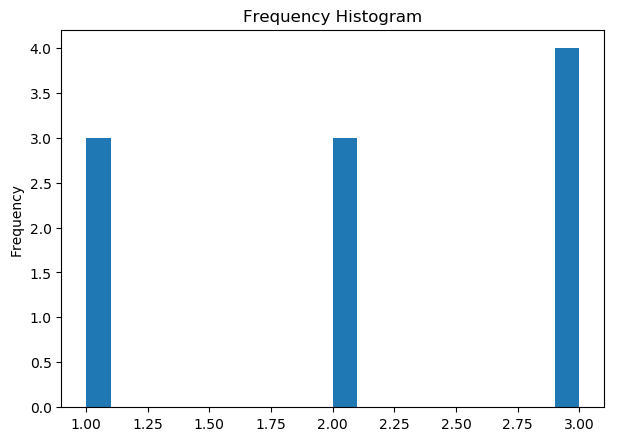

In [10]:
import matplotlib.pyplot as plt
#np.savetxt("Active.csv", active2, delimiter=",", fmt='%d')
#data=genfromtxt('Active.csv',delimiter=',')
#print(data)
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
#x = data
x= active2
plt.hist(x, bins=20)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

